## Skeleton to implement 3D harmonic oscillator PES code in python.
## NOTE: Please find commments with NOTE to see current limitations of code.

# Step 0 a) Loading up needed modules.

In [2]:
%%time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import scipy
from scipy import special
from os import path
mpl.rcParams['font.size'] = 12

CPU times: user 2.36 s, sys: 454 ms, total: 2.81 s
Wall time: 329 ms


# Step 0 b) Classes.

In [3]:
%%time
###########
# Classes #
###########

# Potentials.
class densities(object):
    def __init__(self,ngausshermx,ngausshermy,ngausshermz):
        self.rho = np.zeros([2,ngausshermx,ngausshermy,ngausshermz]) # First index is isospin.
        self.tau = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.kappa = np.zeros([2,ngausshermx,ngausshermy,ngausshermz]) + 1j*0.0 # Complex number.
        self.divJ = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.laplrho = np.zeros([2,ngausshermx,ngausshermy,ngausshermz]) # Convenient to compute.
        
# Potentials.
class potentials(object):
    def __init__(self,ngausshermx,ngausshermy,ngausshermz):
        self.effmass = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.ure = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.wx = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.wy = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.wz = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
        self.delta = np.zeros([2,ngausshermx,ngausshermy,ngausshermz]) + 0.0*1j  
        
# Coupling constants for energy density functional.
class ccedf(object):
    def __init__(self, iforce, isospin):
        if iforce == 7: # SeaLL1 (Phys Rev C 97, 044313). 
            # Homogenous interaction term.
            self.a0 = 0.0
            self.b0 = -684.524043779
            self.c0 = 827.26287841
            self.a1 = 64.2474102072
            self.b1 = 119.862146959
            self.c1 = -256.492703921
            self.a2 = -96.8354102072
            self.b2 = 449.22189682
            self.c2 = -461.650174489
            # Gradient term.
            self.etas = 81.3917529003
            self.claplrho0 = -0.5*self.etas
            self.claplrho1 = -0.5*self.etas
            self.claplrhop = self.claplrho0 + isospin*self.claplrho1
            self.claplrhon = self.claplrho0 - isospin*self.claplrho1
            # Spin orbit.
            self.w0 = 73.5210618422
            self.cdivJ0 = -self.w0
            self.cdivJ1 = 0.0
            self.cdivJp = self.cdivJ0 + isospin*self.cdivJ1
            self.cdivJn = self.cdivJ0 - isospin*self.cdivJ1
            # Kinetic terms.
            self.ctau0 = 0.0
            self.ctau1 = 0.0
            self.ctaup = self.ctau0 + isospin*self.ctau1
            self.ctaun = self.ctau0 - isospin*self.ctau1            
            # Pairing coupling constants.
            self.gg0p = -200.0
            self.gg0n = -200.0

CPU times: user 34 µs, sys: 1e+03 ns, total: 35 µs
Wall time: 37.2 µs


# Step 0 c) Functions.

In [19]:
%%time
##############################
# Functions Related to Basis #
##############################

# Counts total number of allowed states given nshells. 
def obtainNumStates(nshells):
    nstates = 0
    for i in range(nshells):
        for ix in range(i+1): # ix can go from 0 to N, which is represented by i. 
            for iy in range(i+1): # ix can go from 0 to N, which is represented by i. 
                for iz in range(i+1): # ix can go from 0 to N, which is represented by i. 
                    if iz+iy+ix != i:
                        continue
                    nstates +=1     
    return nstates

# Records the energies and quantum numbers of the allowed states.
def obtainQuanNums(nstates,nshells,hbaromegax,hbaromegay,hbaromegaz):
    eho = np.zeros(nstates)
    qnums = np.zeros([4,nstates])
    ifill = 0
    for i in range(nshells):
        for ix in range(i+1): # ix can go from 0 to N, which is represented by i. 
            for iy in range(i+1): # ix can go from 0 to N, which is represented by i. 
                for iz in range(i+1): # ix can go from 0 to N, which is represented by i. 
                    if iz+iy+ix != i:
                        continue
                    eho[ifill] = hbaromegax*(ix+0.5)+hbaromegay*(iy+0.5)+hbaromegaz*(iz+0.5)
                    qnums[0,ifill] = i
                    qnums[1,ifill] = ix
                    qnums[2,ifill] = iy
                    qnums[3,ifill] = iz
                    ifill +=1 # For spin!          
    return eho, qnums

# Normalization of Hermite polynomial.
def normHermite(nx): 
    Nnx = np.sqrt(1/(np.sqrt(np.pi)*2.0**nx*math.factorial(int(nx))))
    return Nnx

# Normalization array of Hermite polynomial for a given number of shells.
def normHermite1D(nshells):
    normhermx = np.zeros(nshells)
    for i in range(nshells):
        normhermx[i]=normHermite(i)
    return normhermx

# Returns Gauss-Hermite quadrature points, weights, and spatial coordinates.  
def quadCoordinates(ngauss,betax):
    # Defining quadrature points and weights.
    xix, xiwx = np.polynomial.hermite.hermgauss(ngauss)
    xiwx = xiwx/np.exp(-xix**2.0) 
    # Corresponding values in coordinate space.
    x = xix/betax
    return xix, xiwx, x

# Constructing basis functions along 1 dimension. 
def basisHermite(ngauss,nshells,normherm,xix):
    # Initialization.
    basisherm = np.zeros([ngauss,nshells]) 
    # Filling in basis functions.
    for i in range(nshells):
        function = special.hermite(int(i), monic=True)  
        fact=2.0**i*np.exp(-xix**2.0/2.0) # Extra factor of 2.0^nx is required
        basisherm[:,i]= function(xix)*normherm[i]*fact 
    return basisherm

# Constructing basis derivatives along 1 dimension. 
def dbasisHermite(hbaromega,hbar2m,basisherm,ngauss,nshells,xix):
    # Pre factor.  
    factor = -0.5*np.sqrt(hbaromega/hbar2m)
    # Initialization.
    dbasisherm = np.zeros([ngauss,nshells]) 
    # Filling in basis functions.
    for i in range(nshells):
        if i == 0:
            dbasisherm[:,i]= np.sqrt(i+1.0)*basisherm[:,i+1]
        else:
            dbasisherm[:,i]= np.sqrt(i+1.0)*basisherm[:,i+1]-np.sqrt(i)*basisherm[:,i-1]
    dbasisherm = factor*dbasisherm
    return dbasisherm

# Constructing basis 2nd derivatives along 1 dimension. 
def ddbasisHermite(hbaromega,hbar2m,basisherm,ngauss,nshells,xix):
    # Pre factor.  
    factor = 0.25*hbaromega/hbar2m
    # Initialization.
    ddbasisherm = np.zeros([ngauss,nshells]) 
    # Filling in basis functions.
    for i in range(nshells):
        if i == 0:
            ddbasisherm[:,i]= np.sqrt(i+2.0)*np.sqrt(i+1.0)*basisherm[:,i+2]\
            -(i + 1)*basisherm[:,i]       
        elif i == 1:
            ddbasisherm[:,i]= np.sqrt(i+2.0)*np.sqrt(i+1.0)*basisherm[:,i+2]\
            -(2*i + 1)*basisherm[:,i]          
        else:
            ddbasisherm[:,i]= np.sqrt(i+2.0)*np.sqrt(i+1.0)*basisherm[:,i+2]\
            -(2*i + 1)*basisherm[:,i]\
            +np.sqrt(i)*np.sqrt(i-1.0)*basisherm[:,i-2]
    ddbasisherm = factor*ddbasisherm
    return ddbasisherm

# Constructing basis 2nd derivatives along 1 dimension. 
def dddbasisHermite(hbaromega,hbar2m,basisherm,ngauss,nshells,xix): # TESTING.
    # Pre factor.  
    factor = -0.125*(hbaromega/hbar2m)**(3.0/2.0)
    # Initialization.
    dddbasisherm = np.zeros([ngauss,nshells]) 
    # Filling in basis functions.
    for i in range(nshells):
        if i == 0:
            dddbasisherm[:,i]= np.sqrt(i+3.0)*np.sqrt(i+2.0)*np.sqrt(i+1.0)*basisherm[:,i+3] \
            - (3.0*i+3)*np.sqrt(i+1.0)*basisherm[:,i+1] 
        elif i == 1:
            dddbasisherm[:,i]= np.sqrt(i+3.0)*np.sqrt(i+2.0)*np.sqrt(i+1.0)*basisherm[:,i+3] \
            - (3.0*i+3)*np.sqrt(i+1.0)*basisherm[:,i+1] \
            + (2.0*i+1)*np.sqrt(i)*basisherm[:,i-1]
        elif i == 2:
            dddbasisherm[:,i]= np.sqrt(i+3.0)*np.sqrt(i+2.0)*np.sqrt(i+1.0)*basisherm[:,i+3] \
            - (3.0*i+3)*np.sqrt(i+1.0)*basisherm[:,i+1] \
            + (3.0*i)*np.sqrt(i)*basisherm[:,i-1]          
        else:
            dddbasisherm[:,i]= np.sqrt(i+3.0)*np.sqrt(i+2.0)*np.sqrt(i+1.0)*basisherm[:,i+3] \
            - (3.0*i+3)*np.sqrt(i+1.0)*basisherm[:,i+1] \
            + (3.0*i)*np.sqrt(i)*basisherm[:,i-1] \
            - np.sqrt(i)*np.sqrt(i-1.0)*np.sqrt(i-2.0)*basisherm[:,i-3]
    dddbasisherm = factor*dddbasisherm
    return dddbasisherm

# Constructs basis functions along 3 dimensions.  
def basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,basishermy,basishermz):
    # Precompute indices
    nxvalues = qnums[1, :].astype(int)
    nyvalues = qnums[2, :].astype(int)
    nzvalues = qnums[3, :].astype(int)
    # Initialize arrays.
    basisfull = np.zeros((nstates,ngausshermx,ngausshermy,ngausshermz))
    # Basis states.
    for i in range(nstates):
        basisfull[i] = (
            np.outer(basishermx[:, nxvalues[i]], 
                     np.outer(basishermy[:, nyvalues[i]], 
                              basishermz[:, nzvalues[i]]
                             ).reshape(-1)
                    ).reshape(ngausshermx, ngausshermy, ngausshermz)
        )
    return basisfull 

# Computes first derivative for Hermite polynomials. 
def D1(xix,bx,nshells,dbasis,ddbasis):
    Nx = len(xix)
    D = np.zeros((Nx,Nx),dtype=np.float64)
    for i in range(Nx):
        for j in range(Nx):
            if i == j:
                D[i][j] = 0.5*ddbasis[:,nshells+1][i]/dbasis[:,nshells+1][j]
            else: 
                D[i][j] = dbasis[:,nshells+1][i]/(dbasis[:,nshells+1][j]*(xix[i] - xix[j]))
    return D

# Computes second derivative for Hermite polynomials. 
def D2(xix,hbaromega,hbar2m,nshells,dbasis,ddbasis,dddbasis):
    Nx = len(xix)
    D = np.zeros((Nx,Nx),dtype=np.float64)
    for i in range(Nx):
        for j in range(Nx):
            if i == j:
                D[i][j] = (2*hbar2m/hbaromega)* dddbasis[:,nshells+1][i]/(3.0*dbasis[:,nshells+1][j]) # Need to understand constant eventually. 
            else:
                # Remove the first term from the analytic expression since it's zero anyway.
                D[i][j] = - 2.0*dbasis[:,nshells+1][i]/(dbasis[:,nshells+1][j] * (xix[i] - xix[j])**2)                            
    return D
    
##################################
# Functions Related to Densities #
##################################

# Defines erf function in 1-D for initializing densities.
def erf(x,lx): 
    erffunc = np.zeros(lx)
    for i in range(lx):
        erffunc[i] = 1.0-math.erf(x[i])
    return erffunc

# Computes 3d integral.
def integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,integrand):
    integrand1 = np.trapz(integrand, z, axis=2) # NOTE: should use something more accurate than trapz. 
    integrand2 = np.trapz(integrand1, y, axis=1)
    sums = np.trapz(integrand2, x)
    return sums
    
# Initializes densities to a Gaussian esq function normalized to yield approximately the correct number of neutrons and protons.  
# Should be extended to non spherical starting densities.  
def initDens(A,N,npoints,ngausshermx,ngausshermy,ngausshermz,x,y,z,beta_y,beta_z):
    x0 = 1.2*A**(1./3.)
    params_init = [x0,0.08] # initialization for norm and shift for the error function
    def find_x0(params,ngausshermx,ngausshermy,ngausshermz,x,y,z,N,beta_y,beta_z):
        rho_x = erf((np.abs(x) - params[0])/1.8,ngausshermx) # Note: 1.8 controls the diffuseness of the surface.
        rho_y = erf((np.abs(y) - params[0]*beta_y)/1.8 ,ngausshermy)
        rho_z = erf((np.abs(z) - params[0]*beta_z)/1.8,ngausshermz)
        rho = params[1]*np.outer(rho_x, np.outer(rho_y, rho_z).reshape(-1)).reshape(ngausshermx, ngausshermy, ngausshermz)
        integral = integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,rho)
        N_eqn = integral - N #Constrain the integral of rho to be the number of particles N.
        max_eqn = np.max(rho) - 0.08 #Constrain the max of the function to be saturation density .16 fm^-3
        return [N_eqn,max_eqn]
    root = scipy.optimize.fsolve(find_x0,params_init,args=(ngausshermx,ngausshermy,ngausshermz,x,y,z,N,beta_y,beta_z))
    # Computes correct density.
    # 1D densities.
    rho_x = erf((np.abs(x)-root[0])/1.8,ngausshermx)
    rho_y = erf((np.abs(y)-root[0]*beta_y)/1.8,ngausshermy)
    rho_z = erf((np.abs(z)-root[0]*beta_z)/1.8,ngausshermz)
    # 3D density.
    rho = root[1]* np.outer(rho_x, np.outer(rho_y, rho_z).reshape(-1)).reshape(ngausshermx, ngausshermy, ngausshermz)
    return rho

# Computes number density.
def compRho(wavf,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates):
    vup = wavf[2*ngausshermxyz:3*ngausshermxyz,2*nstates:4*nstates]
    vdown = wavf[3*ngausshermxyz:4*ngausshermxyz,2*nstates:4*nstates]
    rhoup = np.sum(np.abs(vup)**2.0,axis=1)
    rhodown = np.sum(np.abs(vdown)**2.0,axis=1)
    rho = rhoup + rhodown
    rho = rho.reshape(ngausshermx,ngausshermy,ngausshermz)
    return rho

# Compute kinetic density.
def compTau(wavfx,wavfy,wavfz,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates):
    vxup = wavfx[2*ngausshermxyz:3*ngausshermxyz,2*nstates:4*nstates]
    vxdown = wavfx[3*ngausshermxyz:4*ngausshermxyz,2*nstates:4*nstates]
    vyup = wavfy[2*ngausshermxyz:3*ngausshermxyz,2*nstates:4*nstates]
    vydown = wavfy[3*ngausshermxyz:4*ngausshermxyz,2*nstates:4*nstates]
    vzup = wavfz[2*ngausshermxyz:3*ngausshermxyz,2*nstates:4*nstates]
    vzdown = wavfz[3*ngausshermxyz:4*ngausshermxyz,2*nstates:4*nstates]
    tauxup = np.sum(np.abs(vxup)**2.0,axis=1)
    tauxdown = np.sum(np.abs(vxdown)**2.0,axis=1)
    tauyup = np.sum(np.abs(vyup)**2.0,axis=1)
    tauydown = np.sum(np.abs(vydown)**2.0,axis=1)
    tauzup = np.sum(np.abs(vzup)**2.0,axis=1)
    tauzdown = np.sum(np.abs(vzdown)**2.0,axis=1)
    tau = tauxup + tauxdown + tauyup + tauydown + tauzup + tauzdown
    tau = tau.reshape(ngausshermx,ngausshermy,ngausshermz)
    return tau   

# Compute anomalous density.
def compKappa(wavf,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates):
    uup = wavf[0:ngausshermxyz,2*nstates:4*nstates]
    udown = wavf[ngausshermxyz:2*ngausshermxyz,2*nstates:4*nstates]
    vup = wavf[2*ngausshermxyz:3*ngausshermxyz,2*nstates:4*nstates]
    vdown = wavf[3*ngausshermxyz:4*ngausshermxyz,2*nstates:4*nstates]
    kappa = np.sum(0.5*(np.conj(vdown)*uup - np.conj(vup)*udown),axis=1)
    kappa = kappa.reshape(ngausshermx,ngausshermy,ngausshermz)
    return kappa
    
###################################
# Functions Related to Potentials #
###################################

# Constructs potentials from densities.
def constPots(pots,dens,hbar2m,ccedfp,ccedfn,iharmonic,ngausshermx,ngausshermy,ngausshermz):
    # Defining the effective mass (simple for SeaLL1).
    pots.effmass[:,:,:,:] = hbar2m # NOTE: will not be trivial for other EDFs.
    # Defining sum and difference of densities. 
    esp = 10**(-14.0) # Prevents division by zero. 
    rho0 = dens.rho[0,:,:,:]+dens.rho[1,:,:,:]
    rho1 = dens.rho[0,:,:,:]-dens.rho[1,:,:,:]
    # Powers of densities.
    rho0_p2d3 = rho0**(2.0/3.0)
    rho0_p4d3 = rho0**(4.0/3.0)
    rho0_p10d3 = rho0**(10.0/3.0)
    rho0_p3 = rho0**(3.0)
    rho0_p8d3 = rho0**(8.0/3.0)
    rho0_p1d3 = rho0**(1.0/3.0)
    rho0_p2 = rho0**(2.0)
    rho0_p7d3 = rho0**(7.0/3.0)
    rho0_p5d3 = rho0**(5.0/3.0)
    rho1_p3 = rho1**(3.0)
    # Defining the central potential.
    for iso in range(2):
        if iso == 0: # Protons interaction term.
            sign = + 1
            pots.ure[iso,:,:,:] = 5.0/3.0*ccedfp.a0*rho0_p2d3 \
            + 2.0*ccedfp.b0*rho0 \
            + 7.0/3.0*ccedfp.c0*rho0_p4d3 \
            - 1.0/3.0*ccedfp.a1*rho1**2.0/(rho0_p4d3+esp) \
            + 1.0/3.0*ccedfp.c1*rho1**2.0/(rho0_p2d3+esp) \
            - 7.0/3.0*ccedfp.a2*rho1**4.0/(rho0_p10d3+esp) \
            - 2.0*ccedfp.b2*rho1**4.0/(rho0_p3+esp) \
            - 5.0/3.0*ccedfp.c2*rho1**4.0/(rho0_p8d3+esp) \
            + sign*(2.0*ccedfp.a1*rho1/(rho0_p1d3+esp) \
            + 2.0*ccedfp.b1*rho1 \
            + 2.0*ccedfp.c1*rho1*rho0_p8d3 \
            + 4.0*ccedfp.a2*rho1_p3/(rho0_p7d3+esp) \
            + 4.0*ccedfp.b2*rho1_p3/(rho0_p2+esp) \
            + 4.0*ccedfp.c2*rho1_p3/(rho0_p5d3+esp)) \
            + ccedfp.claplrhop*dens.laplrho[0,:,:,:]+ccedfp.claplrhon*dens.laplrho[1,:,:,:] \
            + ccedfp.cdivJp*dens.divJ[0,:,:,:]+ccedfp.cdivJn*dens.divJ[1,:,:,:] 
        else: # Neutrons interaction term.
            sign =  - 1
            pots.ure[iso,:,:,:] = 5.0/3.0*ccedfn.a0*rho0_p2d3 \
            + 2.0*ccedfn.b0*rho0 \
            + 7.0/3.0*ccedfn.c0*rho0_p4d3 \
            - 1.0/3.0*ccedfn.a1*rho1**2.0/(rho0_p4d3+esp) \
            + 1.0/3.0*ccedfn.c1*rho1**2.0/(rho0_p2d3+esp) \
            - 7.0/3.0*ccedfn.a2*rho1**4.0/(rho0_p10d3+esp) \
            - 2.0*ccedfn.b2*rho1**4.0/(rho0_p3+esp) \
            - 5.0/3.0*ccedfn.c2*rho1**4.0/(rho0_p8d3+esp) \
            + sign*(2.0*ccedfn.a1*rho1/(rho0_p1d3+esp) \
            + 2.0*ccedfn.b1*rho1 \
            + 2.0*ccedfn.c1*rho1*rho0_p8d3 \
            + 4.0*ccedfn.a2*rho1_p3/(rho0_p7d3+esp) \
            + 4.0*ccedfn.b2*rho1_p3/(rho0_p2+esp) \
            + 4.0*ccedfn.c2*rho1_p3/(rho0_p5d3+esp)) \
            + ccedfn.claplrhop*dens.laplrho[0,:,:,:]+ccedfn.claplrhon*dens.laplrho[1,:,:,:] \
            + ccedfn.cdivJp*dens.divJ[0,:,:,:]+ccedfn.cdivJn*dens.divJ[1,:,:,:]         
    # Harmonic oscillator potential (for testing purposes).
    if iharmonic == 1:
        oscx = 0.25*(1/hbar2m)*hbaromegax**2.0
        oscy = 0.25*(1/hbar2m)*hbaromegay**2.0
        oscz = 0.25*(1/hbar2m)*hbaromegaz**2.0
        for iso in range(2):
            for ix in range(ngausshermx):
                for iy in range(ngausshermy):
                    for iz in range(ngausshermz):
                        pots.ure[iso,ix,iy,iz] = oscx*x[ix]**2.0 + oscy*y[iy]**2.0 + oscz*z[iz]**2.0 
    
# Renormalizing coupling constant (NOTE: more complicated once we switch away from SeaLL1 and have a non trivial effective mass).  
def renormPaircoupling(pots,mup,mun,ccedfp,ccedfn,ngausshermx,ngausshermy,ngausshermz):
    pc = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    ureal = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    for iso in range(2):
        if iso == 0:
            ureal[iso,:,:,:] = pots.ure[iso,:,:,:] - mup
        else:
            ureal[iso,:,:,:] = pots.ure[iso,:,:,:] - mun
        p0 = np.sqrt(np.abs(ureal)/pots.effmass)
        for ix in range(ngausshermx):
            for iy in range(ngausshermy):
                for iz in range(ngausshermz):
                    if ecut > ureal[iso,ix,iy,iz]:
                        pc[iso,ix,iy,iz] = np.sqrt((ecut - ureal[iso,ix,iy,iz])/pots.effmass[iso,ix,iy,iz])
                        if ureal[iso,ix,iy,iz] < 0.0:
                            pc[iso,ix,iy,iz] = pc[iso,ix,iy,iz] - 0.5*p0[iso,ix,iy,iz]*np.log((pc[iso,ix,iy,iz]+p0[iso,ix,iy,iz])/(pc[iso,ix,iy,iz]-p0[iso,ix,iy,iz]))
                        else:
                            pc[iso,ix,iy,iz] = pc[iso,ix,iy,iz] + p0[iso,ix,iy,iz]*np.arctan(p0[iso,ix,iy,iz]/pc[iso,ix,iy,iz])
                    else:
                        pc[iso,ix,iy,iz] = 0.0           
    geffp = ccedfp.gg0p*(1.0-ccedfp.gg0p*pc[0,:,:,:]/(4*np.pi**2.0*pots.effmass[0,:,:,:]))
    geffn = ccedfn.gg0n*(1.0-ccedfp.gg0p*pc[1,:,:,:]/(4*np.pi**2.0*pots.effmass[1,:,:,:]))
    # NOTE: Spherical cutoff is used, but perhaps cubic cutoff should be used instead, or at least added as a option.  
    return geffp, geffn

# Constructs pairing field from anomalous density.
def constDelta(pots,dens,geffp,geffn,iconstpair):
    # Initial pairing field.
    pots.delta[0,:,:,:] = -geffp*dens.kappa[0,:,:,:] + 0.0*1j
    pots.delta[1,:,:,:] = -geffn*dens.kappa[1,:,:,:] + 0.0*1j
    if iconstpair == 1:
        pots.delta[0,:,:,:] = -40.0
        pots.delta[1,:,:,:] = -40.0

##########################################
# Functions Related to Coulomb Potential #
##########################################

# Computes laplaciean of number density.  
def compLaplrho(rho,x,y,z):
    d2rho_dx2 = np.gradient(np.gradient(rho,x,axis=0),x, axis=0) # NOTE: better function than gradient should be used.
    d2rho_dy2 = np.gradient(np.gradient(rho,y,axis=1),y, axis=1)
    d2rho_dz2 = np.gradient(np.gradient(rho,z,axis=2),z, axis=2)
    laplrho = d2rho_dx2 + d2rho_dy2 + d2rho_dz2
    return laplrho

# Computes direct contribution of Coulomb potential. 
def compVcouldirect(e2,laplrho,ngausshermx,ngausshermy,ngausshermz,x,y,z): # Note: should update Coulomb using Antonio Bjelčić procedure.
    # Initializing arrays.  
    vcdir = np.zeros([ngausshermx,ngausshermy,ngausshermz])
    # Mesh grid to speed up calculation.
    Xp, Yp, Zp = np.meshgrid(x, y, z, indexing="ij")
    # Computing all points in vcdir.
    for ix in range(ngausshermx):
        for iy in range(ngausshermy):
            for iz in range(ngausshermz):
                # Computing integrand.  
                rmrp = np.sqrt((x[ix] - Xp)**2 + (y[iy] - Yp)**2 + (z[iz] - Zp)**2)
                integrand = rmrp * laplrho
                vcdir[ix,iy,iz] = integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,integrand)
    vcdir = 0.5*e2*vcdir
    return vcdir

# Computes exchange contribution of Coulomb potential.  
def compVcoulexchange(e2,rhop):
    vcex = -e2*(3.0*rhop/np.pi)**(1./3.)
    return vcex

##############################################
# Functions Related to Spin Orbit Potential. #
##############################################

# Computes gradient of number density.  
def compGradrho(rho,ngausshermx,ngausshermy,ngausshermz,x,y,z):
    drhox = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    drhoy = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    drhoz = np.zeros([2,ngausshermx,ngausshermy,ngausshermz])
    for iso in range(2):
        drhox[iso,:,:,:] = np.gradient(rho[iso,:,:,:],x,axis=0) # NOTE: better function than gradient should be used.
        drhoy[iso,:,:,:] = np.gradient(rho[iso,:,:,:],y,axis=1)
        drhoz[iso,:,:,:] = np.gradient(rho[iso,:,:,:],z,axis=2)
    return drhox, drhoy, drhoz

# Computes spin orbit potential.
def compWso(pots,ccedf,drhox,drhoy,drhoz,isospin):
    if isospin == 1: 
        iso = 0
    elif isospin == -1:
        iso = 1
    pots.wx[iso,:,:,:] = ccedf.cdivJp*drhox[0,:,:,:] + ccedf.cdivJn*drhox[1,:,:,:]  
    pots.wy[iso,:,:,:] = ccedf.cdivJp*drhoy[0,:,:,:] + ccedf.cdivJn*drhoy[1,:,:,:]
    pots.wz[iso,:,:,:] = ccedf.cdivJp*drhoz[0,:,:,:] + ccedf.cdivJn*drhoz[1,:,:,:]
    # Note: does not have 0.5 factor because we do not symmetrize, but should be double checked in future.   

#####################################
# Functions Related to Hamiltonian. #
#####################################
    
# Computes 3D integral using Gauss-Hermite quad.
def integrate3DGH(xiwx,xiwy,xiwz,integrand):
    integral1 = np.sum(integrand*xiwz,axis=-1)
    integral2 = np.sum(integral1*xiwy,axis=-1)
    sums = np.sum(integral2*xiwx)
    return sums

# Computes Hamiltonian. 
def compHam(ndim,iso,pots,mu,xiwx,xiwy,xiwz,basisfull,dxbasisfull,dybasisfull,dzbasisfull,qnums):
    # Initialize matrix.
    ndim2 = 2*ndim
    ndim4 = 4*ndim
    hamp = np.zeros([ndim4, ndim4])+0.0*1j # Spin and u,v components.
    # Filling matrix (lower triangle). 
    for i in range(ndim4):
        iuv = i // ndim2
        ispin = (i // ndim) % 2
        ixyz = i % ndim
        for j in range(ndim4):
            juv = j // ndim2 
            jspin = (j // ndim) % 2
            jxyz = j % ndim
            if i >= j: # Lower triangle.
                # Normal part.
                if iuv == juv:
                    if iuv == 0:
                        dsign = +1 # U component.
                    else:
                        dsign = -1 # V component.
                    # Diagonal spin contribution.  
                    if ispin==jspin:
                        # Central potential.
                        integrand = pots.ure[iso, :, :, :] * basisfull[ixyz, :, :, :] * basisfull[jxyz, :, :, :]
                        integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                        hamp[i,j] = hamp[i,j] + dsign*integral
                        # Sigma z part of spin orbit.
                        if ispin == 0: # NOTE: Correct upto minus sign, which should still be checked.   
                            integrand = -1j*basisfull[ixyz, :, :, :] * (pots.wx[iso, :, :, :] * dybasisfull[jxyz, :, :, :]-\
                                                                pots.wy[iso, :, :, :] * dxbasisfull[jxyz, :, :, :])
                            integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                            if iuv == 0:
                                hamp[i,j] = hamp[i,j] + dsign*integral 
                            else:
                                hamp[i,j] = hamp[i,j] + dsign*np.conj(integral) 
                        else:
                            integrand = 1j*basisfull[ixyz, :, :, :] * (pots.wx[iso, :, :, :] * dybasisfull[jxyz, :, :, :]-\
                                                                    pots.wy[iso, :, :, :] * dxbasisfull[jxyz, :, :, :])
                            integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                            if iuv == 0:
                                hamp[i,j] = hamp[i,j] + dsign*integral 
                            else:
                                hamp[i,j] = hamp[i,j] + dsign*np.conj(integral) 
                        # Chemical potential.
                        if i==j:
                            hamp[i,j] = hamp[i,j] - dsign*mu
                        # Kinetic part. NOTE: Currently only programmed for SeaLL1. 
                        # If we have an actual effective mass we need derivative basis functions and to perform an integral.  
                        # NOTE: have to be careful if states are |0> or |1>. 
                        if qnums[2,ixyz]==qnums[2,jxyz] and qnums[3,ixyz]==qnums[3,jxyz]: # x component. 
                            if qnums[1,ixyz] == qnums[1,jxyz]:      
                                hamp[i,j] = hamp[i,j] + dsign*0.25*hbaromegax*(2*qnums[1,jxyz]+1.0)
                            if qnums[1,ixyz] == qnums[1,jxyz]-2.0:      
                                hamp[i,j] = hamp[i,j] - dsign*0.25*hbaromegax*np.sqrt(qnums[1,jxyz])*np.sqrt(qnums[1,jxyz]-1.0)
                            if qnums[1,ixyz] == qnums[1,jxyz]+2.0:      
                                hamp[i,j] = hamp[i,j] - dsign*0.25*hbaromegax*np.sqrt(qnums[1,jxyz]+1.0)*np.sqrt(qnums[1,jxyz]+2.0)
                        if qnums[1,ixyz]==qnums[1,jxyz] and qnums[3,ixyz]==qnums[3,jxyz]: # y component. 
                            if qnums[2,ixyz] == qnums[2,jxyz]:      
                                hamp[i,j] = hamp[i,j] + dsign*0.25*hbaromegay*(2*qnums[2,jxyz]+1.0)
                            if qnums[2,ixyz] == qnums[2,jxyz]-2.0:      
                                hamp[i,j] = hamp[i,j] - dsign*0.25*hbaromegay*np.sqrt(qnums[2,jxyz])*np.sqrt(qnums[2,jxyz]-1.0)
                            if qnums[2,ixyz] == qnums[2,jxyz]+2.0:      
                                hamp[i,j] = hamp[i,j] - dsign*0.25*hbaromegay*np.sqrt(qnums[2,jxyz]+1.0)*np.sqrt(qnums[2,jxyz]+2.0)
                        if qnums[1,ixyz]==qnums[1,jxyz] and qnums[2,ixyz]==qnums[2,jxyz]: # z component. 
                            if qnums[3,ixyz] == qnums[3,jxyz]:      
                                hamp[i,j] = hamp[i,j] + dsign*0.25*hbaromegaz*(2*qnums[3,jxyz]+1.0)
                            if qnums[3,ixyz] == qnums[3,jxyz]-2.0:      
                                hamp[i,j] = hamp[i,j] - dsign*0.25*hbaromegaz*np.sqrt(qnums[3,jxyz])*np.sqrt(qnums[3,jxyz]-1.0)
                            if qnums[3,ixyz] == qnums[3,jxyz]+2.0:      
                                hamp[i,j] = hamp[i,j] - dsign*0.25*hbaromegaz*np.sqrt(qnums[3,jxyz]+1.0)*np.sqrt(qnums[3,jxyz]+2.0)
                    # Off diagonal spin contribution (sigma x and sigma y).
                    if ispin!=jspin:
                        # Sigma x.
                        if ispin != jspin:
                            integrand = -1j*basisfull[ixyz, :, :, :] * (pots.wy[iso, :, :, :] * dzbasisfull[jxyz, :, :, :]-\
                                                                pots.wz[iso, :, :, :] * dybasisfull[jxyz, :, :, :])
                            integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                            if iuv == 0:
                                hamp[i,j] = hamp[i,j] + dsign*integral 
                            else:
                                hamp[i,j] = hamp[i,j] + dsign*np.conj(integral) 
                        # Sigma y. 
                        if ispin != jspin and ispin == 0:
                            integrand = -1.0*basisfull[ixyz, :, :, :] * (pots.wz[iso, :, :, :] * dxbasisfull[jxyz, :, :, :]-\
                                                                pots.wx[iso, :, :, :] * dzbasisfull[jxyz, :, :, :])
                            integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                            if iuv == 0:
                                hamp[i,j] = hamp[i,j] + dsign*integral 
                            else:
                                hamp[i,j] = hamp[i,j] + dsign*np.conj(integral) 
                        if ispin != jspin and ispin == 1:
                            integrand = 1.0*basisfull[ixyz, :, :, :] * (pots.wz[iso, :, :, :] * dxbasisfull[jxyz, :, :, :]-\
                                                                pots.wx[iso, :, :, :] * dzbasisfull[jxyz, :, :, :])
                            integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                            if iuv == 0:
                                hamp[i,j] = hamp[i,j] + dsign*integral 
                            else:
                                hamp[i,j] = hamp[i,j] + dsign*np.conj(integral)                  
                # Pairing part. 
                if iuv != juv:
                    if iuv == 1: # v*u
                        if ispin == 0 and jspin == 1:
                            integrand = -np.conj(pots.delta[iso,:,:,:])* basisfull[ixyz, :, :, :]*basisfull[jxyz, :, :, :]
                            integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                            hamp[i,j] = hamp[i,j] +integral
                        if ispin == 1 and jspin == 0:
                            integrand = np.conj(pots.delta[iso,:,:,:])* basisfull[ixyz, :, :, :]*basisfull[jxyz, :, :, :]
                            integral = integrate3DGH(xiwx,xiwy,xiwz,integrand)
                            hamp[i,j] = hamp[i,j] +integral 
            # DONT FORGET TO CONJUGATE on imaginary off diagonal terms for V as well as the minus sign.
    # Construct upper triangle.  
    hamp = hamp + np.conj(np.transpose(hamp))- np.diag(np.diagonal(hamp)) 
    return hamp    

#######################################
# Functions Related to Wavefunctions. #
#######################################

# Transforms wavefunctions from the oscillator basis to cartesian space.  
def transform_cartesian(basisfull,dxbasisfull,dybasisfull,dzbasisfull,ddxbasisfull,ddybasisfull,ddzbasisfull,\
              ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,\
              eigenvector,nstates,xiwx,xiwy,xiwz,x,y,z):
    # Define transformation matrix.
    nwavf = 4*nstates # Including positive and negative states. 
    Tdims = basisfull.shape
    T = basisfull.reshape(nstates,ngausshermxyz)
    # Define derivative transformation matricies.
    Tx = dxbasisfull.reshape(nstates,ngausshermxyz)
    Ty = dybasisfull.reshape(nstates,ngausshermxyz)
    Tz = dzbasisfull.reshape(nstates,ngausshermxyz)
    Txx = ddxbasisfull.reshape(nstates,ngausshermxyz)
    Tyy = ddybasisfull.reshape(nstates,ngausshermxyz)
    Tzz = ddzbasisfull.reshape(nstates,ngausshermxyz)
    # Construct each wavefunction and derivatives.
    eigenvector_coord = np.zeros([4*ngausshermxyz,nwavf],dtype = np.complex128)
    dxeigenvector_coord = np.zeros([4*ngausshermxyz,nwavf],dtype = np.complex128)
    dyeigenvector_coord = np.zeros([4*ngausshermxyz,nwavf],dtype = np.complex128)
    dzeigenvector_coord = np.zeros([4*ngausshermxyz,nwavf],dtype = np.complex128)
    ddxeigenvector_coord = np.zeros([4*ngausshermxyz,nwavf],dtype = np.complex128)
    ddyeigenvector_coord = np.zeros([4*ngausshermxyz,nwavf],dtype = np.complex128)
    ddzeigenvector_coord = np.zeros([4*ngausshermxyz,nwavf],dtype = np.complex128)
    for k in range(nwavf):
        # Wavefunctions.
        vec = eigenvector[:,k]
        U_up = np.einsum('ij,i->j',T,vec[0:nstates])
        U_down =  np.einsum('ij,i->j',T,vec[nstates:2*nstates])
        V_up =  np.einsum('ij,i->j',T,vec[2*nstates:3*nstates])
        V_down =  np.einsum('ij,i->j',T,vec[3*nstates:4*nstates])
        new_evect = np.hstack((U_up,U_down,V_up,V_down)).reshape(4,ngausshermx,ngausshermy,ngausshermz)
        # Norm.
        norm = integrate3D(xiwx,xiwy,xiwz,x,y,z,np.abs(new_evect[0,:,:,:])**2.0)+\
        integrate3D(xiwx,xiwy,xiwz,x,y,z,np.abs(new_evect[1,:,:,:])**2.0)+\
        integrate3D(xiwx,xiwy,xiwz,x,y,z,np.abs(new_evect[2,:,:,:])**2.0)+\
        integrate3D(xiwx,xiwy,xiwz,x,y,z,np.abs(new_evect[3,:,:,:])**2.0)
        # 1st derivatives.
        Ux_up = np.einsum('ij,i->j',Tx,vec[0:nstates])
        Ux_down =  np.einsum('ij,i->j',Tx,vec[nstates:2*nstates])
        Vx_up =  np.einsum('ij,i->j',Tx,vec[2*nstates:3*nstates])
        Vx_down =  np.einsum('ij,i->j',Tx,vec[3*nstates:4*nstates])
        Uy_up = np.einsum('ij,i->j',Ty,vec[0:nstates])
        Uy_down =  np.einsum('ij,i->j',Ty,vec[nstates:2*nstates])
        Vy_up =  np.einsum('ij,i->j',Ty,vec[2*nstates:3*nstates])
        Vy_down =  np.einsum('ij,i->j',Ty,vec[3*nstates:4*nstates])
        Uz_up = np.einsum('ij,i->j',Tz,vec[0:nstates])
        Uz_down =  np.einsum('ij,i->j',Tz,vec[nstates:2*nstates])
        Vz_up =  np.einsum('ij,i->j',Tz,vec[2*nstates:3*nstates])
        Vz_down =  np.einsum('ij,i->j',Tz,vec[3*nstates:4*nstates])
        # 2nd derivatives.
        Uxx_up = np.einsum('ij,i->j',Txx,vec[0:nstates])
        Uxx_down =  np.einsum('ij,i->j',Txx,vec[nstates:2*nstates])
        Vxx_up =  np.einsum('ij,i->j',Txx,vec[2*nstates:3*nstates])
        Vxx_down =  np.einsum('ij,i->j',Txx,vec[3*nstates:4*nstates])
        Uyy_up = np.einsum('ij,i->j',Tyy,vec[0:nstates])
        Uyy_down =  np.einsum('ij,i->j',Tyy,vec[nstates:2*nstates])
        Vyy_up =  np.einsum('ij,i->j',Tyy,vec[2*nstates:3*nstates])
        Vyy_down =  np.einsum('ij,i->j',Tyy,vec[3*nstates:4*nstates])
        Uzz_up = np.einsum('ij,i->j',Tzz,vec[0:nstates])
        Uzz_down =  np.einsum('ij,i->j',Tzz,vec[nstates:2*nstates])
        Vzz_up =  np.einsum('ij,i->j',Tzz,vec[2*nstates:3*nstates])
        Vzz_down =  np.einsum('ij,i->j',Tzz,vec[3*nstates:4*nstates])
        # Filling in coordinate space wavefunctions.
        eigenvector_coord[:,k] = np.hstack((U_up,U_down,V_up,V_down))/np.sqrt(norm)     
        dxeigenvector_coord[:,k] = np.hstack((Ux_up,Ux_down,Vx_up,Vx_down))/np.sqrt(norm) 
        dyeigenvector_coord[:,k] = np.hstack((Uy_up,Uy_down,Vy_up,Vy_down))/np.sqrt(norm)
        dzeigenvector_coord[:,k] = np.hstack((Uz_up,Uz_down,Vz_up,Vz_down))/np.sqrt(norm) 
        ddxeigenvector_coord[:,k] = np.hstack((Uxx_up,Uxx_down,Vxx_up,Vxx_down))/np.sqrt(norm) 
        ddyeigenvector_coord[:,k] = np.hstack((Uyy_up,Uyy_down,Vyy_up,Vyy_down))/np.sqrt(norm)
        ddzeigenvector_coord[:,k] = np.hstack((Uzz_up,Uzz_down,Vzz_up,Vzz_down))/np.sqrt(norm) 
    return eigenvector_coord, dxeigenvector_coord, dyeigenvector_coord, dzeigenvector_coord,\
    ddxeigenvector_coord, ddyeigenvector_coord, ddzeigenvector_coord

#######################################
# Functions Related to Observables. #
#######################################

def compute_observables(dens,pots,vcdir,xiwx,xiwy,xiwz,x,y,z,X,Y,Z,hbar2m,e2,ccedfp,geffp,geffn):
    # Constants.
    e2exchange = 3.0/2.0*e2*(3/np.pi)**(1.0/3.0)
    esp = 10**(-14.0) # Prevents division by zero. 
    # Observables.
    etot = 0 
    ekin = 0
    erho = 0
    erhotau = 0
    elaplrho = 0
    eso = 0
    epairp = 0 
    epairn = 0 
    ecoul = 0 
    ecouldir = 0 # Still need.
    ecoulex = 0 
    nprot = 0
    nneu = 0
    atot = 0
    pgapp = 0 
    pgapn = 0 
    xcm = 0 
    ycm = 0 
    zcm = 0 
    qxx = 0 
    qyy = 0 
    qzz = 0 
    qxxx = 0 
    qyyy = 0 
    qzzz = 0 
    rmsn = 0 
    rmsp = 0 
    rmstot = 0 
    # Densities.
    rho0 = dens.rho[0,:,:,:] + dens.rho[1,:,:,:]
    rho1 = dens.rho[0,:,:,:] - dens.rho[1,:,:,:]
    tau0 = dens.tau[0,:,:,:] + dens.tau[1,:,:,:]
    tau1 = dens.tau[0,:,:,:] - dens.tau[1,:,:,:]
    divJ0 = dens.divJ[0,:,:,:] + dens.divJ[1,:,:,:]
    divJ1 = dens.divJ[0,:,:,:] - dens.divJ[1,:,:,:]
    laplrho0 = dens.laplrho[0,:,:,:] + dens.laplrho[1,:,:,:]
    laplrho1 = dens.laplrho[0,:,:,:] - dens.laplrho[1,:,:,:]
    # Computing observables.
    # Particle numbers.
    nprot = integrate3D(xiwx,xiwy,xiwz,x,y,z,dens.rho[0,:,:,:])
    nneu = integrate3D(xiwx,xiwy,xiwz,x,y,z,dens.rho[1,:,:,:])
    atot = nprot + nneu
    # Energies.
    ekin = hbar2m*integrate3D(xiwx,xiwy,xiwz,x,y,z,tau0)
    tmp = ccedfp.a0*rho0**(5.0/3.0) +\
    ccedfp.b0*rho0**(2.0) +\
    ccedfp.c0*rho0**(7.0/3.0) +\
    ccedfp.a1*rho1**(2.0)/(rho0**(1.0/3.0) + esp) +\
    ccedfp.b1*rho1**(2.0) +\
    ccedfp.c1*rho1**(2.0)/(rho0**(1.0/3.0) + esp) +\
    ccedfp.a2*rho1**(4.0)/(rho0**(7.0/3.0) + esp) +\
    ccedfp.b2*rho1**(4.0)/(rho0**(2.0) + esp) +\
    ccedfp.c2*rho1**(4.0)/(rho0**(5.0/3.0) + esp)
    erho = integrate3D(xiwx,xiwy,xiwz,x,y,z,tmp)
    tmp = ccedfp.ctau0*tau0*rho0 + ccedfp.ctau1*tau1*rho1
    erhotau = integrate3D(xiwx,xiwy,xiwz,x,y,z,tmp)
    tmp = ccedfp.claplrho0*laplrho0*rho0 + ccedfp.claplrho1*laplrho1*rho1
    elaplrho = integrate3D(xiwx,xiwy,xiwz,x,y,z,tmp)
    tmp = ccedfp.cdivJ0*divJ0*rho0 + ccedfp.cdivJ1*divJ1*rho1
    eso = integrate3D(xiwx,xiwy,xiwz,x,y,z,tmp)  
    ecouldir = integrate3D(xiwx,xiwy,xiwz,x,y,z,vcdir*dens.rho[0,:,:,:]) # NOTE: check if this is correct carefully.
    tmp = e2exchange*dens.rho[0,:,:,:]**(4.0/3.0)
    ecoulex = integrate3D(xiwx,xiwy,xiwz,x,y,z,tmp) 
    ecoul = ecouldir + ecoulex
    epairp = integrate3D(xiwx,xiwy,xiwz,x,y,z,geffp*np.abs(dens.kappa[0,:,:,:])**2.0)
    epairn = integrate3D(xiwx,xiwy,xiwz,x,y,z,geffn*np.abs(dens.kappa[1,:,:,:])**2.0)
    etot = ekin + erho + erhotau + elaplrho + eso + epairn + epairp + ecoul
    # Pairing gaps.
    pgapp = integrate3D(xiwx,xiwy,xiwz,x,y,z,np.abs(pots.delta[0,:,:,:])*dens.rho[0,:,:,:])/nprot
    pgapn = integrate3D(xiwx,xiwy,xiwz,x,y,z,np.abs(pots.delta[1,:,:,:])*dens.rho[1,:,:,:])/nneu
    # Center of masses.
    xcm = integrate3D(xiwx,xiwy,xiwz,x,y,z,X*rho0)/atot
    ycm = integrate3D(xiwx,xiwy,xiwz,x,y,z,Y*rho0)/atot
    zcm = integrate3D(xiwx,xiwy,xiwz,x,y,z,Z*rho0)/atot 
    # Rms radii.
    xsq = (X-xcm)**2.0
    ysq = (Y-ycm)**2.0
    zsq = (Z-zcm)**2.0
    rsq = xsq + ysq + zsq
    rmsp = np.sqrt(integrate3D(xiwx,xiwy,xiwz,x,y,z,rsq*dens.rho[0,:,:,:])/nprot) 
    rmsn = np.sqrt(integrate3D(xiwx,xiwy,xiwz,x,y,z,rsq*dens.rho[1,:,:,:])/nneu) 
    rmstot = np.sqrt(integrate3D(xiwx,xiwy,xiwz,x,y,z,rsq*rho0)/atot) 
    # Deformations.
    qxx = integrate3D(xiwx,xiwy,xiwz,x,y,z,(3*xsq-rsq)*rho0)/atot 
    qyy = integrate3D(xiwx,xiwy,xiwz,x,y,z,(3*ysq-rsq)*rho0)/atot 
    qzz = integrate3D(xiwx,xiwy,xiwz,x,y,z,(3*zsq-rsq)*rho0)/atot
    qxxx = integrate3D(xiwx,xiwy,xiwz,x,y,z,(X-xcm)*(5*xsq-3*rsq)*rho0)/atot 
    qyyy = integrate3D(xiwx,xiwy,xiwz,x,y,z,(Y-ycm)*(5*ysq-3*rsq)*rho0)/atot 
    qzzz = integrate3D(xiwx,xiwy,xiwz,x,y,z,(Z-zcm)*(5*zsq-3*rsq)*rho0)/atot  
    print("etot =",etot,", ekin =",ekin,", erho =",erho,", erhotau =",erhotau,", elaplrho =",elaplrho,", eso =",eso,\
          ", ecoul =",ecoul,", ecouldir =",ecouldir,", ecoulex =",ecoulex)
    print("epairp =",epairp,", epairn =",epairn)
    print("pgapp =",pgapp,", pgapn =",pgapn)
    print("nprot =",nprot,", nneu =",nneu)
    print("rmsn =",rmsn,", rmsp =",rmsp,", rmstot =",rmstot)
    print("xcm =",xcm,", ycm=",ycm,", zcm=",zcm)
    print("qxx =",qxx,", qyy =",qyy,", qzz =",qzz)
    print("qxxx =",qxxx,", qyyy =",qyyy,", qzzz =",qzzz)

CPU times: user 17 µs, sys: 4 µs, total: 21 µs
Wall time: 18.1 µs


# Step 1) Defining the basis.

In [5]:
%%time
# Independent Parameters.
Z = 8 # Proton number.
N = 12 # Neutron number.
nshells = 28 # Number of shells to consider.
ngausshermx = nshells+1 # Number of Gauss Hermite quadrature points in the x direction.
ngausshermy = nshells+1 # Number of Gauss Hermite quadrature points in the y direction.
ngausshermz = nshells+1 # Number of Gauss Hermite quadrature points in the z direction.
# Note: lattice points are automatically fixed by number of shells. 
ecut = 100.0 # Cutoff energy.
betayg = 1.0
betazg = 1.0

# Debug parameters. 
iharmonic = 0 # Uses harmonic oscillator potential for testing purposes. (Should be set to 0 for typical run).  
iconstpair = 0 # Uses a constant pairing field. (Should be set to 0 for typical run). 
isotest = 0 # Uses a vec(W) = vec(r) potential. (Should be set to 0 for typical run).  

# Constants.
massp = 938.272013 
massn = 939.565346 
hbarc = 197.3269631 
hbar2m = pow( hbarc , 2.0 ) / ( massp + massn ) 
mass = (massp + massn)/2.0
alphainv = 137.035999679
e2 = hbarc/alphainv

# Dependent Parameters.
A = N + Z # Mass number.
sfactor = 0.5 # Modifies oscillator frequency from pheonomological form. 
hbaromegax = sfactor*41.0/A**(1.0/3.0) # Oscillator frequency in x direction. Estimate from Ring and Schuck [MeV]. 
hbaromegay = sfactor*41.0/A**(1.0/3.0) # Oscillator frequency in y direction. Estimate from Ring and Schuck [MeV]. 
hbaromegaz = sfactor*41.0/A**(1.0/3.0) # Oscillator frequency in z direction. Estimate from Ring and Schuck [MeV]. 
bx = np.sqrt(2*hbar2m*(1/hbaromegax)) # Oscillator length in x direction.
betax = 1/bx # Oscillator constant in x direction.
by = np.sqrt(2*hbar2m*(1/hbaromegay)) # Oscillator length in y direction.
betay = 1/by # Oscillator constant in z direction.
bz = np.sqrt(2*hbar2m*(1/hbaromegaz)) # Oscillator length in z direction.
betaz = 1/bz # Oscillator constant.
ngausshermxyz = ngausshermx*ngausshermy*ngausshermz # Total "lattice" points.
print("A =", A, "N =", N, "Z =", Z)
print("[MeV] hbaromegax =", hbaromegax, "[MeV] hbaromegay =", hbaromegay, "[MeV] hbaromegaz =", hbaromegaz)

A = 20 N = 12 Z = 8
[MeV] hbaromegax = 7.552264572212793 [MeV] hbaromegay = 7.552264572212793 [MeV] hbaromegaz = 7.552264572212793
CPU times: user 424 µs, sys: 100 µs, total: 524 µs
Wall time: 499 µs


In [6]:
2*(hbar2m/hbaromegax)

5.491205400925021

In [7]:
%%time
# Constructs the basis.
nstates = obtainNumStates(nshells)
eho, qnums = obtainQuanNums(nstates,nshells,hbaromegax,hbaromegay,hbaromegaz)
print(nstates)

4060
CPU times: user 26.6 ms, sys: 1.3 ms, total: 27.9 ms
Wall time: 26.7 ms


# Step 2) Defining the corresponding basis states along each dimension, quadrature points, weights, and spatial coordinates.

In [8]:
%%time
# Defining the normalizations for all basis functions.
normhermx = normHermite1D(nshells+5) # We do +3 to include up to 2nd derivatives. 
normhermy = normHermite1D(nshells+5) 
normhermz = normHermite1D(nshells+5) 

# Defining quadrature points and weights, and corresponding values in coordinate space.
xix, xiwx, x = quadCoordinates(ngausshermx,betax) 
xiy, xiwy, y = quadCoordinates(ngausshermy,betay) 
xiz, xiwz, z = quadCoordinates(ngausshermz,betaz) 

# Filling in basis functions. 
basishermx = basisHermite(ngausshermx,nshells+5,normhermx,xix)
basishermy = basisHermite(ngausshermy,nshells+5,normhermy,xiy)
basishermz = basisHermite(ngausshermz,nshells+5,normhermz,xiz)

# Filling in 1st derivative basis.
dbasishermx = dbasisHermite(hbaromegax,hbar2m,basishermx,ngausshermx,nshells+2,xix)
dbasishermy = dbasisHermite(hbaromegay,hbar2m,basishermy,ngausshermy,nshells+2,xiy)
dbasishermz = dbasisHermite(hbaromegaz,hbar2m,basishermz,ngausshermz,nshells+2,xiz)

# Filling in 2nd derivative basis.
ddbasishermx = ddbasisHermite(hbaromegax,hbar2m,basishermx,ngausshermx,nshells+2,xix)
ddbasishermy = ddbasisHermite(hbaromegay,hbar2m,basishermy,ngausshermy,nshells+2,xiy)
ddbasishermz = ddbasisHermite(hbaromegaz,hbar2m,basishermz,ngausshermz,nshells+2,xiz)

# Filling in 3rd derivative basis.
dddbasishermx = dddbasisHermite(hbaromegax,hbar2m,basishermx,ngausshermx,nshells+2,xix)
dddbasishermy = dddbasisHermite(hbaromegay,hbar2m,basishermy,ngausshermy,nshells+2,xiy)
dddbasishermz = dddbasisHermite(hbaromegaz,hbar2m,basishermz,ngausshermz,nshells+2,xiz)

CPU times: user 24.8 ms, sys: 5.19 ms, total: 30 ms
Wall time: 26.7 ms


CPU times: user 25.2 ms, sys: 4.64 ms, total: 29.8 ms
Wall time: 29.5 ms


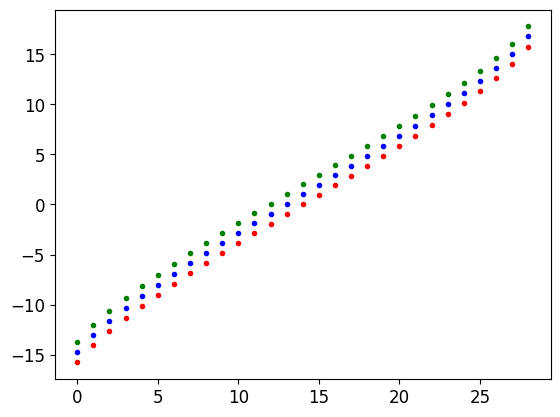

In [9]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Plotting coordinates (shifted slightly).
plt.plot(x,'.r')
plt.plot(y+1,'.b')
plt.plot(z+2,'.g')

# Testing normalization of Hermite basis functions.
for i in range(nshells+1):
    test = np.sum(basishermx[:,i]*basishermx[:,i]*xiwx)
    if np.abs(test-1.0) > 1e-6:
        print(i,np.sum(basishermx[:,i]*basishermx[:,i]*xiwx))
    test = np.sum(basishermy[:,i]*basishermy[:,i]*xiwy)
    if np.abs(test-1.0) > 1e-6:
        print(i,np.sum(basishermy[:,i]*basishermy[:,i]*xiwy))
    test = np.sum(basishermz[:,i]*basishermz[:,i]*xiwz)
    if np.abs(test-1.0) > 1e-6:
        print(i,test)

# Step 3) Defining the 3D HO eigenfunctions.

In [10]:
%%time
# Computes basis in 3D.
# X, Y, Z = np.meshgrid(x, y, z, indexing='ij') # Spatial basis in 3D
basisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,basishermy,basishermz)
dxbasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,dbasishermx,basishermy,basishermz)
dybasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,dbasishermy,basishermz)
dzbasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,basishermy,dbasishermz)
ddxbasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,ddbasishermx,basishermy,basishermz)
ddybasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,ddbasishermy,basishermz)
ddzbasisfull = basis3D(qnums,nstates,ngausshermx, ngausshermy, ngausshermz,basishermx,basishermy,ddbasishermz)

CPU times: user 509 ms, sys: 169 ms, total: 678 ms
Wall time: 679 ms


In [13]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Testing normalization of the full basis functions
for i in range(nstates):
    integrand1 = np.sum(basisfull[i,  :, :, :]**2 * xiwz, axis=-1)  # Summing over the last axis
    integrand2 = np.sum(integrand1 * xiwy, axis=-1)  # Summing over the `iy` axis
    integrand3 = np.sum(integrand2 * xiwz, axis=-1)  # Summing over the `ix` axis
    sums = np.sum(integrand3)  # Summing over spins
    if np.abs(sums - 1.0) > 1e-6:
        print(i, sums)

CPU times: user 15.2 ms, sys: 2.4 ms, total: 17.6 ms
Wall time: 16 ms


# Step 4) Defining the initial densities. 

In [42]:
# Initializing the densities. 
dens = densities(ngausshermx,ngausshermy,ngausshermz)

In [43]:
%%time
# Constructing starting densities (currently spherical).
dens.rho[0,:,:,:] = initDens(A,Z,1000,ngausshermx,ngausshermy,ngausshermz,x,y,z,betayg,betazg)
dens.rho[1,:,:,:] = initDens(A,N,1000,ngausshermx,ngausshermy,ngausshermz,x,y,z,betayg,betazg)
dens.kappa=0.08*dens.rho+0.0*1j # NEEDS SOMETHING
print("Z (start) N (start):")
print(integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,dens.rho[0,:,:,:]),\
                  integrate3D(ngausshermx,ngausshermy,ngausshermz,x,y,z,dens.rho[1,:,:,:]))

Z (start) N (start):
8.000000000013307 11.999999997694358
CPU times: user 5.51 ms, sys: 2.47 ms, total: 7.98 ms
Wall time: 5.83 ms


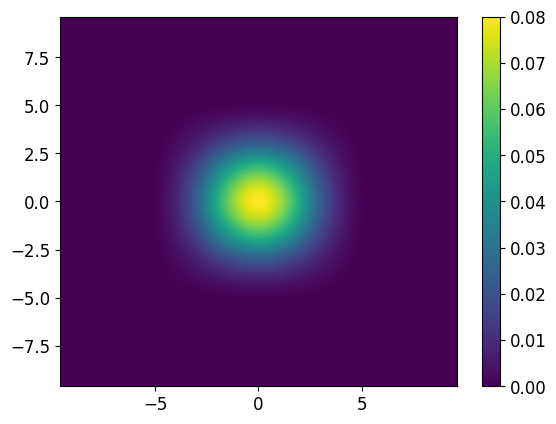

CPU times: user 169 ms, sys: 5.64 ms, total: 175 ms
Wall time: 71.2 ms


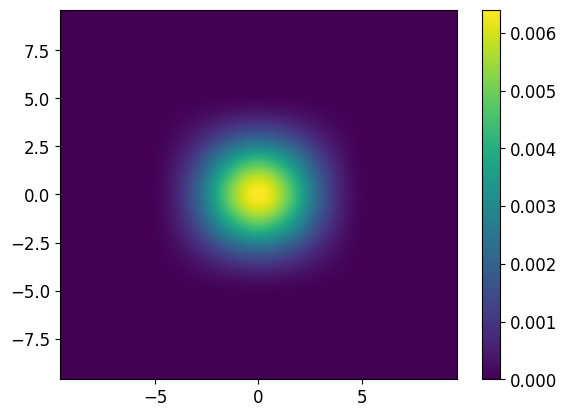

In [46]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Density profile.
plt.imshow(dens.rho[0,:,int(ngausshermy/2),:],extent=[x[0], x[-1], z[0], z[-1]],\
           origin='lower', aspect='auto', cmap='viridis',interpolation='spline16')
plt.colorbar()
plt.show()
# Anom density profile.
plt.imshow(np.abs(dens.kappa[0,:,int(ngausshermy/2),:]),extent=[x[0], x[-1], z[0], z[-1]],\
           origin='lower', aspect='auto', cmap='viridis',interpolation='spline16')
plt.colorbar()

# Step 5) Constructing the initial potentials.

In [13]:
%%time
# Setting the coupling constants.
ccedfp = ccedf(7,1) # Protons.
ccedfn = ccedf(7,-1) # Neutrons.

CPU times: user 34 µs, sys: 1e+03 ns, total: 35 µs
Wall time: 39.3 µs


In [14]:
%%time
# Initializing the potentials. 
pots = potentials(ngausshermx,ngausshermy,ngausshermz)

# Initial chemical potentials.
mup = -12.5
mun = -12.5

# Constructs potentials. 
# Central potential.
dens.laplrho[0,:,:,:] = compLaplrho(dens.rho[0,:,:,:],x,y,z)
dens.laplrho[1,:,:,:] = compLaplrho(dens.rho[1,:,:,:],x,y,z)
constPots(pots,dens,hbar2m,ccedfp,ccedfn,iharmonic,ngausshermx,ngausshermy,ngausshermz)
# Pairing contribution.
geffp, geffn = renormPaircoupling(pots,mup,mun,ccedfp,ccedfn,ngausshermx,ngausshermy,ngausshermz)
constDelta(pots,dens,geffp,geffn,iconstpair)
# Coulomb potentials.
vcdir = compVcouldirect(e2,dens.laplrho[0,:,:,:],ngausshermx,ngausshermy,ngausshermz,x,y,z) # A bit slow and perhaps not super accurate.  
vcex = compVcoulexchange(e2,dens.rho[0,:,:,:])
pots.ure[0,:,:,:] = pots.ure[0,:,:,:] + vcex + vcdir
# Spin orbit potentials. 
drhox,drhoy,drhoz = compGradrho(dens.rho,ngausshermx,ngausshermy,ngausshermz,x,y,z)
compWso(pots,ccedfp,drhox,drhoy,drhoz,1)
compWso(pots,ccedfp,drhox,drhoy,drhoz,-1)
if isotest == 1:
    Xp, Yp, Zp = np.meshgrid(x, y, z, indexing="ij")
    acoeff = 5.0
    for iso in range(2):
        pots.wx[iso,:,:,:] = acoeff*Xp
        pots.wy[iso,:,:,:] = acoeff*Yp
        pots.wz[iso,:,:,:] = acoeff*Zp

CPU times: user 263 ms, sys: 7.61 ms, total: 270 ms
Wall time: 268 ms


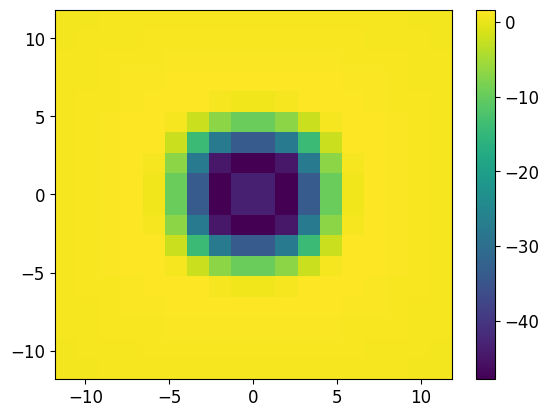

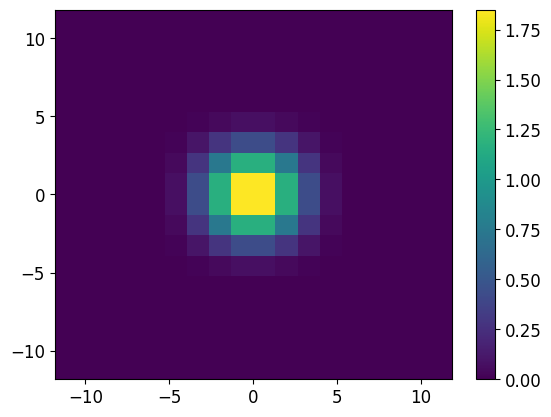

CPU times: user 276 ms, sys: 8.93 ms, total: 285 ms
Wall time: 114 ms


In [15]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Central potential.
plt.imshow(pots.ure[0,:,int(ngausshermy/2),:],extent=[x[0], x[-1], z[0], z[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

# Magnitude of pairing field.
plt.imshow(np.abs(pots.delta[0,:,int(ngausshermy/2),:]),extent=[x[0], x[-1], z[0], z[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

# Main Loop.
# Step 6) Constructing the Hamiltonian.

In [16]:
%%time
# Construct Hamiltonian.
hamp = compHam(nstates,0,pots,mup,xiwx,xiwy,xiwz,basisfull,dxbasisfull,dybasisfull,dzbasisfull,qnums)
hamn = compHam(nstates,1,pots,mun,xiwx,xiwy,xiwz,basisfull,dxbasisfull,dybasisfull,dzbasisfull,qnums)

CPU times: user 1min 7s, sys: 14.6 s, total: 1min 22s
Wall time: 1min 22s


CPU times: user 17.7 ms, sys: 3.46 ms, total: 21.2 ms
Wall time: 20.5 ms


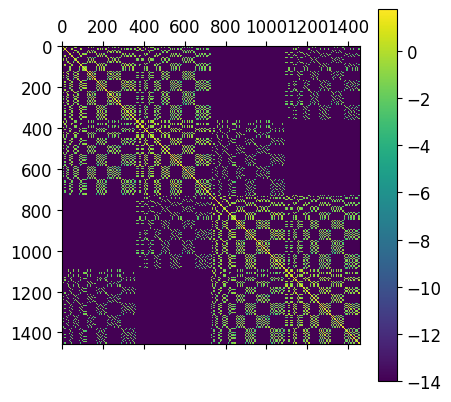

In [17]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
plt.matshow(np.log10(np.abs(hamp)+1e-14))
#plt.contourf()
plt.colorbar()

In [18]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Check if matrix is Hermitian. (Forced to be due to construction).  
print(np.sum(np.abs(hamp-np.conj(np.transpose(hamp)))))
print(np.sum(np.abs(hamn-np.conj(np.transpose(hamn)))))

1.4839016406889716e-15
1.4839016406889716e-15
CPU times: user 55.1 ms, sys: 6.8 ms, total: 61.9 ms
Wall time: 22.1 ms


# Step 7) Diagonalizing the Hamiltonian to obtain the eigenvectors and values.

In [19]:
%%time
# Diagonalize Hamiltonian. 
qpesp,eigvp = np.linalg.eigh(hamp)
qpesn,eigvn = np.linalg.eigh(hamn)
# Obtain single particle energies.
spesp, tmp = np.linalg.eigh(hamp[0:2*nstates,0:2*nstates])
spesn, tmp = np.linalg.eigh(hamn[0:2*nstates,0:2*nstates])

CPU times: user 20 s, sys: 491 ms, total: 20.5 s
Wall time: 2.11 s


In [20]:
%%time
# Recording quasi-particle energies, single particle energies, and occupation numbers.
# Occupation numbers.
occsp = np.zeros(2*nstates)
occsn = np.zeros(2*nstates)
for i in range(2*nstates):
    occsp[i] = np.sum(np.abs(eigvp[2*nstates:4*nstates,2*nstates+i])**2.0)
    occsn[i] = np.sum(np.abs(eigvn[2*nstates:4*nstates,2*nstates+i])**2.0)
print("N = ", np.sum(occsn), "Z = ", np.sum(occsp))
print("mun = ", mun, "mup = ", mup)
# Saving qpes, spes, and occs.
np.savetxt('qpen.txt', np.c_[spesn,qpesn[2*nstates:4*nstates],occsn])
np.savetxt('qpep.txt', np.c_[spesp,qpesp[2*nstates:4*nstates],occsp])

N =  7.839036863414574 Z =  11.565643251354334
mun =  -12.5 mup =  -12.5
CPU times: user 38.9 ms, sys: 194 ms, total: 233 ms
Wall time: 26.5 ms


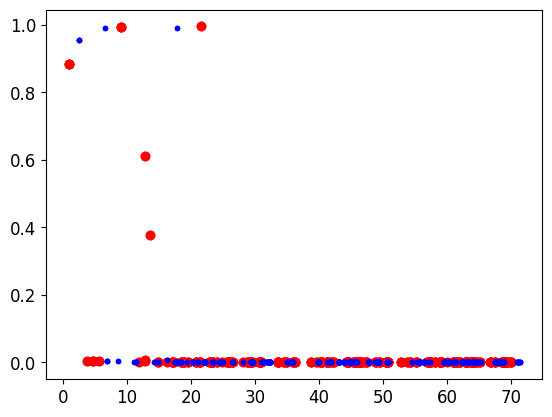

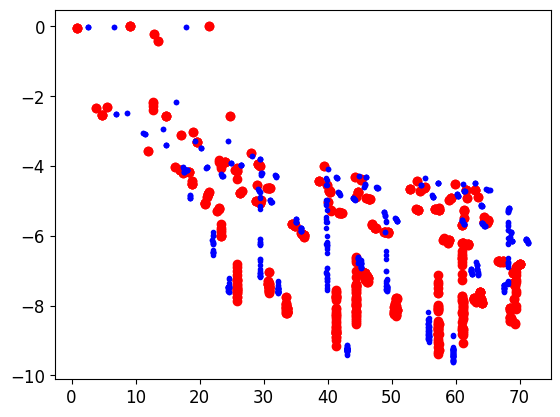

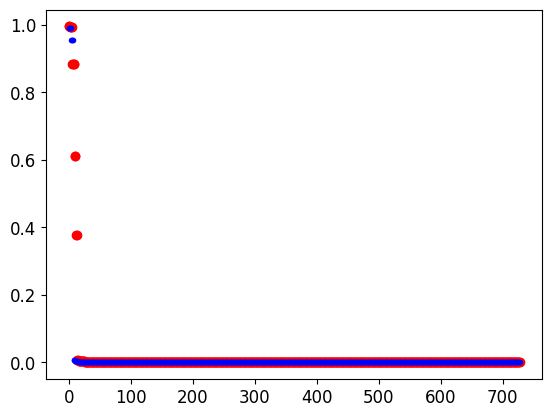

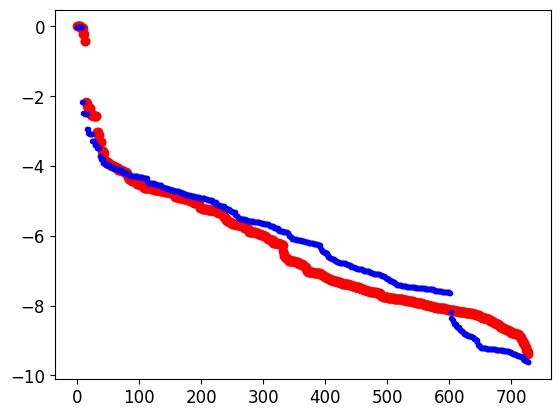

CPU times: user 462 ms, sys: 1.59 s, total: 2.05 s
Wall time: 221 ms


In [21]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Examining spectrum.  
plt.plot(qpesp[2*nstates:4*nstates],occsp,'or')
plt.plot(qpesn[2*nstates:4*nstates],occsn,'.b')
plt.show()
# Examining spectrum in log scale.  
plt.plot(qpesp[2*nstates:4*nstates],np.log10(occsp),'or')
plt.plot(qpesn[2*nstates:4*nstates],np.log10(occsn),'.b')
plt.show()
# Examining spectrum in linear scale vs index and sorted.
plt.plot(np.flip(np.sort(occsp)),'or')
plt.plot(np.flip(np.sort(occsn)),'.b')
plt.show()
# Examining spectrum in log scale vs index and sorted.
plt.plot(np.flip(np.sort(np.log10(occsp))),'or')
plt.plot(np.flip(np.sort(np.log10(occsn))),'.b')
plt.show()

# Step 8) Obtaining the densities (with cutoff on number of quasi-particle wavefunctions).

In [22]:
# Computing wavefunctions in coordinate space.  
wavfp_coord, wavfp_x_coord, wavfp_y_coord, wavfp_z_coord,  wavfp_xx_coord, wavfp_yy_coord, wavfp_zz_coord =\
transform_cartesian(basisfull,dxbasisfull,dybasisfull,dzbasisfull,ddxbasisfull,ddybasisfull,ddzbasisfull,\
          ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,eigvp,nstates,xiwx,xiwy,xiwz,x,y,z)
wavfn_coord, wavfn_x_coord, wavfn_y_coord, wavfn_z_coord,  wavfn_xx_coord, wavfn_yy_coord, wavfn_zz_coord =\
transform_cartesian(basisfull,dxbasisfull,dybasisfull,dzbasisfull,ddxbasisfull,ddybasisfull,ddzbasisfull,\
          ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,eigvn,nstates,xiwx,xiwy,xiwz,x,y,z)

In [23]:
# Compute number densities.
dens.rho[0,:,:,:] = compRho(wavfp_coord,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates)
dens.rho[1,:,:,:] = compRho(wavfn_coord,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates)
# Compute kinetic densities.
dens.tau[0,:,:,:] = compTau(wavfp_x_coord,wavfp_y_coord,wavfp_z_coord,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates)
dens.tau[1,:,:,:] = compTau(wavfn_x_coord,wavfn_y_coord,wavfn_z_coord,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates)
# Compute divergence of spin current density.
# NOTE: STILL NEEDS TO BE DONE.
# Compute anomolous density.
dens.kappa[0,:,:,:] = compKappa(wavfp_coord,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates)
dens.kappa[1,:,:,:] = compKappa(wavfn_coord,ngausshermxyz,ngausshermx,ngausshermy,ngausshermz,nstates)

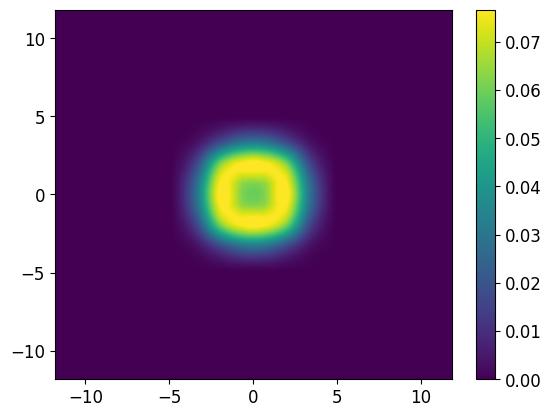

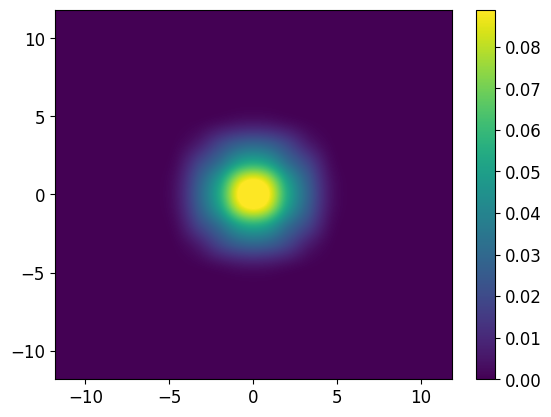

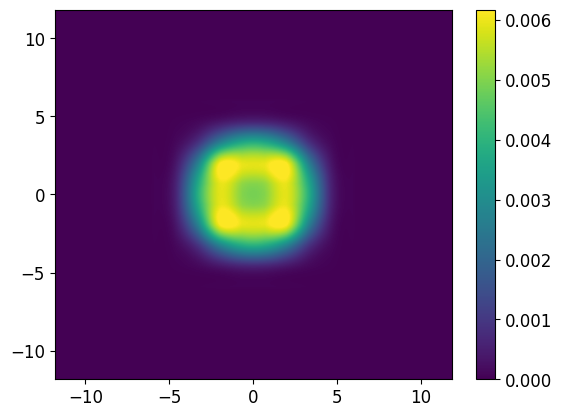

CPU times: user 421 ms, sys: 7.78 ms, total: 428 ms
Wall time: 153 ms


In [24]:
%%time
#######################################
# IGNORE or REMOVE, CONSISTENCY TESTS #
#######################################
# Density profile.
plt.imshow(dens.rho[0,:,int(ngausshermy/2),:],extent=[x[0], x[-1], z[0], z[-1]],\
           origin='lower', aspect='auto', cmap='viridis',interpolation='spline16')
plt.colorbar()
plt.show()
# Kinetic density profile.
plt.imshow(dens.tau[0,:,int(ngausshermy/2),:],extent=[x[0], x[-1], z[0], z[-1]],\
           origin='lower', aspect='auto', cmap='viridis',interpolation='spline16')
plt.colorbar()
plt.show()
# Anomalous density profile.
plt.imshow(np.abs(dens.kappa[0,:,int(ngausshermy/2),:]),extent=[x[0], x[-1], z[0], z[-1]],\
           origin='lower', aspect='auto', cmap='viridis',interpolation='spline16')
plt.colorbar()
plt.show()

# Step 9) Creating new potentials and storing old potentials.

# Step 10) Extracting observables and checking convergence (if success skip to Step 12 - our of loop).

In [333]:
compute_observables(dens,pots,vcdir,xiwx,xiwy,xiwz,x,y,z,X,Y,Z,hbar2m,e2,ccedfp,geffp,geffn)

etot = -139.4913276372015 , ekin = 325.4265038136067 , erho = -536.5782112823952 , erhotau = 0.0 , elaplrho = 22.654917258343154 , eso = 0.0 , ecoul = 51.97711575227992 , ecouldir = 43.39756098258214 , ecoulex = 8.579554769697777
epairp = -1.609684296529749 , epairn = -1.3619688825063865
pgapp = 0.7764199522953412 , pgapn = 1.1559418680339786
nprot = 11.553122527603056 , nneu = 7.842924702786298
rmsn = 2.606729035751088 , rmsp = 2.89077486182088 , rmstot = 2.779416965326315
xcm = -8.228200204617804e-18 , ycm= -5.329139644892425e-17 , zcm= -3.2144709837842165e-17
qxx = 0.0008320426829157662 , qyy = -0.0008061652422522601 , qzz = -2.5877440663922808e-05
qxxx = 1.0303137647521424e-15 , qyyy = -3.5040446725709796e-16 , qzzz = -2.8541829801898662e-15


# Step 11) Updating chemical potential and mixing potentials. 

In [147]:
# Return back to Step 6.

# Step 12) Writing restart densities, potentials, or wavefunctions if desired.  

# Notes from Eric. 

$ \rho = V^{*}V^{T}$
Our eigenvectors are calculated from numpy's diagonalization routine. The form of the eigenvectors are 

$\psi_{k} = \begin{pmatrix}
U_{k,\uparrow,n_{x}*n_{y}*n_{z}} \\
U_{k,\downarrow,n_{x}*n_{y}*n_{z}} \\
V_{k,\uparrow, n_{x}*n_{y}*n_{z}} \\
V_{k,\downarrow,n_{x}*n_{y}*n_{z}}
\end{pmatrix}$

Here $k$ is labeling the eigenvector, $\uparrow$ and $\downarrow$ label spin up and spin down, and $n_{x}$, $n_{y}$, $n_{z}$ are the number of harmonic oscillator states (analogous to coordinate space lattice points) in $x,y,z$.
So for the eigenvector coming from numpy, we have for example eigvp which will have shape  4 * nstates x 4 * nstates where nstates is the total number of harmonic oscillator states that statisfy N = nx + ny + nz. The columns of eigvp are labeled by k and represent the eigenvalue-eigenvector pair. We want to take the positive eigenvalues solutions to the HFB equation so we always start the k at k = 2*nstates. 

evect = eigvp[:,2*nstates] picks out the first eigstate we want.
Next, we have a single raveled vector that contains all the U and V vectors.
So for example, if we want to pick out the $V_{\uparrow}$ components, we would take 
Vup = evect[3*nstates:4*nstates]
and so on. 

Putting these indices together in one line, 

Vup = evect[:3*nstates:4*nstates,2*nstates]